In [1]:
import os
import time
import pickle
import numpy as np
import networkx as nx
import metropolis as mt
import matplotlib.pyplot as plt
from seaborn import color_palette
from matplotlib.colors import LinearSegmentedColormap

In [2]:
RES_PATH = './output/regression_residual'
GRAPH_PATH = './output/graph_test'
if not os.path.exists(RES_PATH):
    os.mkdir(RES_PATH)
if not os.path.exists(GRAPH_PATH):
    os.mkdir(GRAPH_PATH)

In [2]:
RETURN_PATH = './intermediate/daily_return'
data = np.loadtxt(RETURN_PATH + '/all.txt')

In [3]:
with open('./output/samples_capm.txt', 'rb') as f:
    capm_samples_dict = pickle.load(f)
capm_state_samples = capm_samples_dict['state_samples']
capm_sigma_samples = capm_samples_dict['sigma_samples']
capm_G_samples = capm_samples_dict['graph_samples']
capm_beta_samples = capm_samples_dict['beta_samples']
capm_tran_matrix_samples = capm_samples_dict['transition_matrix_samples']

In [5]:
with open('./output/samples_thr.txt', 'rb') as f:
    thr_samples_dict = pickle.load(f)
thr_state_samples = thr_samples_dict['state_samples']
thr_sigma_samples = thr_samples_dict['sigma_samples']
thr_G_samples = thr_samples_dict['graph_samples']
thr_beta_samples = thr_samples_dict['beta_samples']
thr_tran_matrix_samples = thr_samples_dict['transition_matrix_samples']

In [4]:
np.sum(capm_state_samples,1)

array([1518., 1492., 1488., ..., 1487., 1516., 1492.])

In [6]:
np.sum(thr_state_samples,1)

array([891., 897., 902., ..., 903., 881., 901.])

In [ ]:
capm_high = np.where(np.mean(capm_state_samples, axis=0) < 0.5)[0]
capm_high_data = data[capm_high]
capm_low=np.where(np.mean(capm_state_samples, axis=0) > 0.5)[0]
capm_low_data = data[capm_low]

thr_high = np.where(np.mean(thr_state_samples, axis=0) > 0.5)[0]
thr_high_data = data[thr_high]
thr_low=np.where(np.mean(thr_state_samples, axis=0) < 0.5)[0]
thr_low_data = data[thr_low]

In [11]:
# load data
y = np.loadtxt(RETURN_PATH + '/all.txt')
capm = np.loadtxt('./intermediate/factors/capm.txt')
thr_factors = np.loadtxt('./intermediate/factors/thr_factors.txt')
(T, p) = y.shape
capm_factor_num = capm.shape[1]
capm_n = p * capm_factor_num
capm_x = np.zeros([T, capm_n, p])
for i in range(0, T):
    capm_x[i] = np.kron(np.eye(p), capm[i]).T

thr_factor_num = thr_factors.shape[1]
thr_n = p * thr_factor_num
thr_x = np.zeros([T, thr_n, p])
for i in range(0, T):
    thr_x[i] = np.kron(np.eye(p), thr_factors[i]).T

In [11]:
capm_mean_beta = np.mean(capm_beta_samples, axis=0)
capm_high_residual = np.zeros([len(capm_high), p])
capm_low_residual = np.zeros([len(capm_low), p])
for i in range(0, len(capm_high)):
    capm_high_residual[i] = data[capm_high[i]] - np.dot(capm_x[capm_high[i]].T, capm_mean_beta[0])
for i in range(0, len(capm_low)):
    capm_low_residual[i] = data[capm_low[i]] - np.dot(capm_x[capm_low[i]].T, capm_mean_beta[1])
np.savetxt(RES_PATH + "/capm_high_residual.txt", capm_high_residual)
np.savetxt(RES_PATH + "/capm_low_residual.txt", capm_low_residual)

In [12]:
thr_mean_beta = np.mean(thr_beta_samples, axis=0)
thr_high_residual = np.zeros([len(thr_high), p])
thr_low_residual = np.zeros([len(thr_low), p])
for i in range(0, len(thr_high)):
    thr_high_residual[i] = data[thr_high[i]] - np.dot(thr_x[thr_high[i]].T, thr_mean_beta[1])
for i in range(0, len(thr_low)):
    thr_low_residual[i] = data[thr_low[i]] - np.dot(thr_x[thr_low[i]].T, thr_mean_beta[0])
np.savetxt(RES_PATH + "/thr_high_residual.txt", thr_high_residual)
np.savetxt(RES_PATH + "./thr_low_residual.txt", thr_low_residual)

In [13]:
len(capm_high)

940

In [14]:
len(thr_high_residual)

894

In [15]:
delta = 3
tau = 0.0004
rho = 0

In [59]:
start_time = time.time()
G1=mt.metropolis_hastings(capm_low_residual, delta, tau, rho, 1000000)
end_time1 = time.time()
print "time cost: {}s".format(round(end_time1 - start_time, 2))

time cost: 3857.75s


In [60]:
start_time = time.time()
G2=mt.metropolis_hastings(capm_high_residual, delta, tau, rho, 1000000)
end_time2 = time.time()
print "time cost: {}s".format(round(end_time2 - start_time, 2))
capm_G = [G1, G2]

time cost: 3857.75s


In [61]:
start_time = time.time()
G3=mt.metropolis_hastings(thr_low_residual, delta, tau, rho, 1000000)
end_time3 = time.time()
print "time cost: {}s".format(round(end_time3 - start_time, 2))

time cost: 3477.07s


In [61]:
start_time = time.time()
G4=mt.metropolis_hastings(thr_high_residual, delta, tau, rho, 1000000)
end_time4 = time.time()
print "time cost: {}s".format(round(end_time4 - start_time, 2))
thr_G = [G3, G4]

time cost: 3477.07s


In [3]:
G1=nx.from_numpy_array(np.loadtxt(GRAPH_PATH + '/G1.txt'))
G2=nx.from_numpy_array(np.loadtxt(GRAPH_PATH + '/G2.txt'))
G3=nx.from_numpy_array(np.loadtxt(GRAPH_PATH + '/G3.txt'))
G4=nx.from_numpy_array(np.loadtxt(GRAPH_PATH + '/G4.txt'))

In [5]:
capm_G = [G1, G2]
thr_G = [G3, G4]

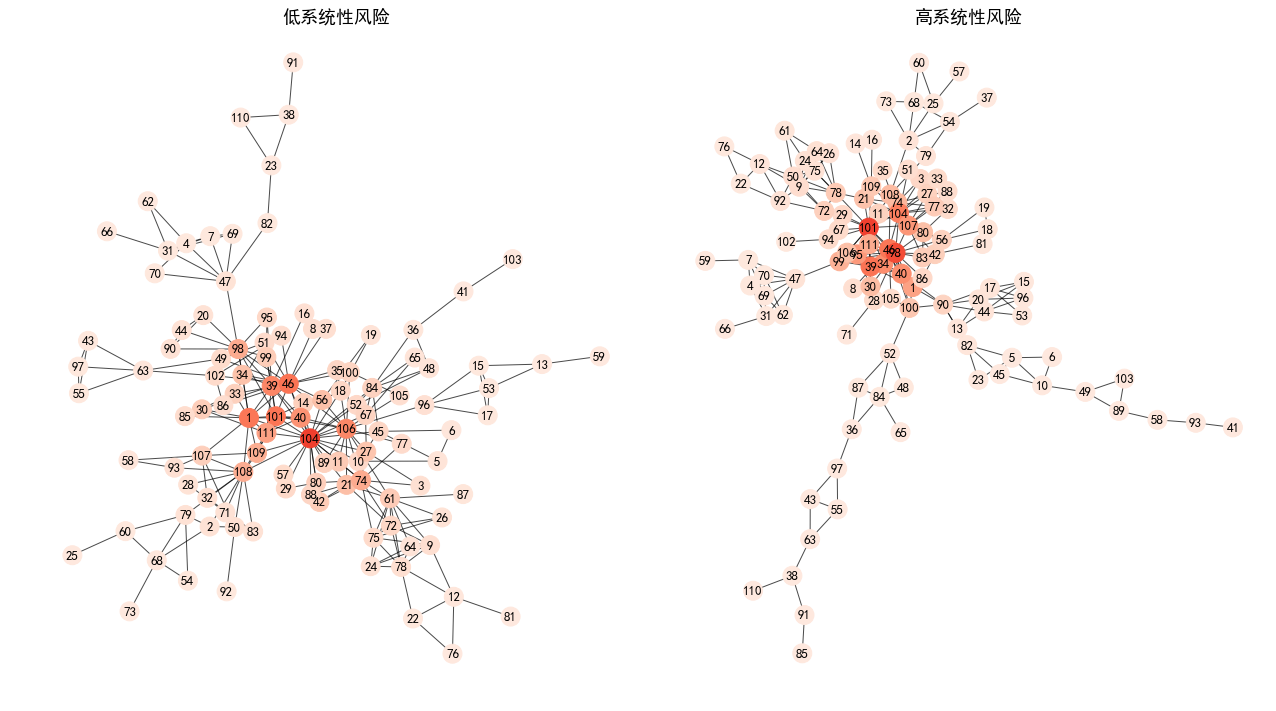

In [27]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# Draw weighted networks example
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,10))
fig.tight_layout(pad=2, h_pad=1, w_pad=1)
labels = {0:u"高", 1:u"低"}
nodes_name = {i:i+1 for i in range(0, 111)}
for k in [1,0]:
    G_example = capm_G[k]
    pos = nx.kamada_kawai_layout(G_example)
    importance_dict = nx.eigenvector_centrality_numpy(G_example)
    nx.draw_networkx_edges(G_example, pos, alpha=0.7, ax=ax[1-k])
    nx.draw_networkx_nodes(G_example, pos, nodelist=list(importance_dict.keys()),
                           node_size=360,
                           node_color=list(importance_dict.values()),
                           cmap=LinearSegmentedColormap.from_list('a', color_palette("Reds", n_colors=12)[:8]),
                           ax=ax[1-k])
    nx.draw_networkx_labels(G_example, pos, labels=nodes_name, ax=ax[1-k], font_color='black', font_size=13)
    ax[1-k].set_title(labels[k] + u"系统性风险", fontsize=18)
    ax[1-k].axis('off')
plt.show()
fig.savefig(GRAPH_PATH + "/test_capm.png")

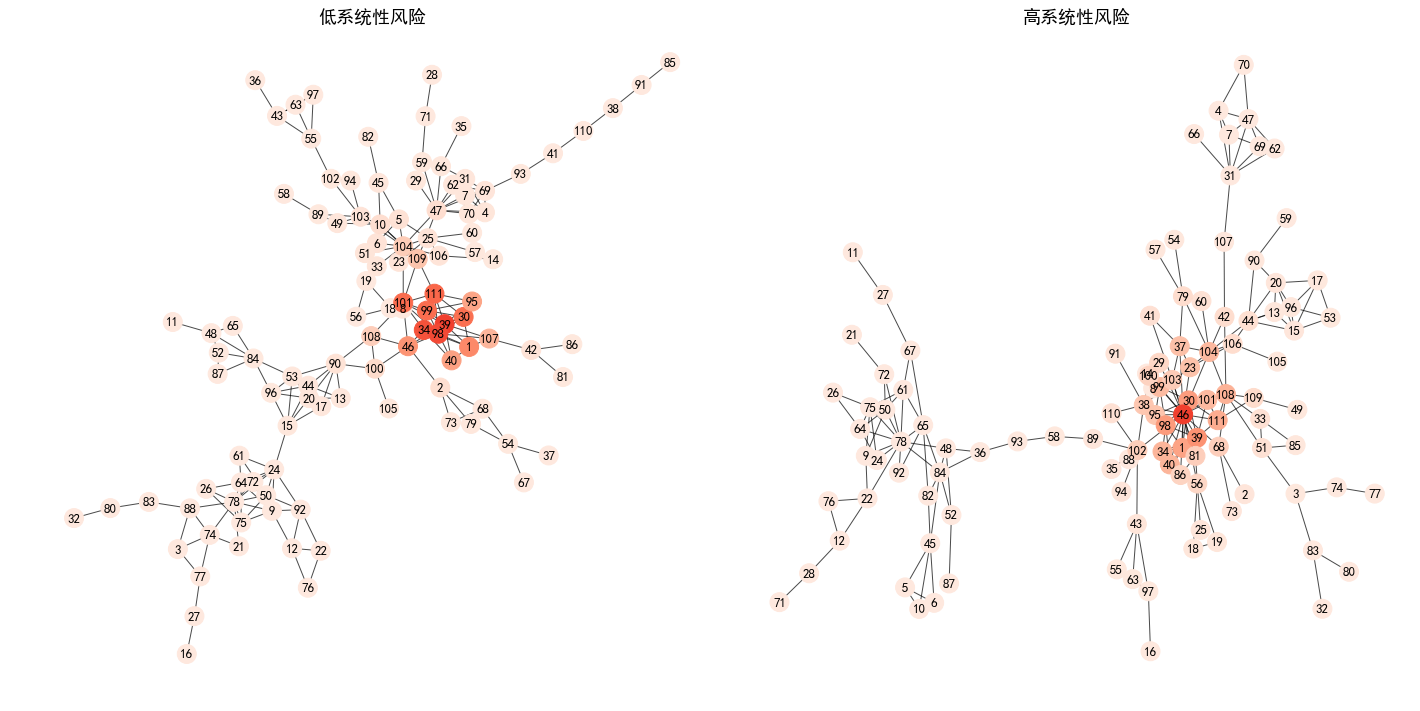

In [6]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# Draw weighted networks example
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
fig.tight_layout(pad=2, h_pad=1, w_pad=1)
labels = {1:u"高", 0:u"低"}
nodes_name = {i:i+1 for i in range(0, 111)}
for k in range(0, 2):
    G_example = thr_G[k]
    pos = nx.kamada_kawai_layout(G_example)
    importance_dict = nx.eigenvector_centrality_numpy(G_example)
    nx.draw_networkx_edges(G_example, pos, alpha=0.7, ax=ax[k])
    nx.draw_networkx_nodes(G_example, pos, nodelist=list(importance_dict.keys()),
                           node_size=360,
                           node_color=list(importance_dict.values()),
                           cmap=LinearSegmentedColormap.from_list('a', color_palette("Reds", n_colors=12)[:8]),
                           ax=ax[k])
    nx.draw_networkx_labels(G_example, pos, labels=nodes_name, ax=ax[k], font_color='black', font_size=13)
    ax[k].set_title(labels[k] + u"系统性风险",fontsize=18)
    ax[k].axis('off')
plt.show()
fig.savefig(GRAPH_PATH + "/test_thr.png")